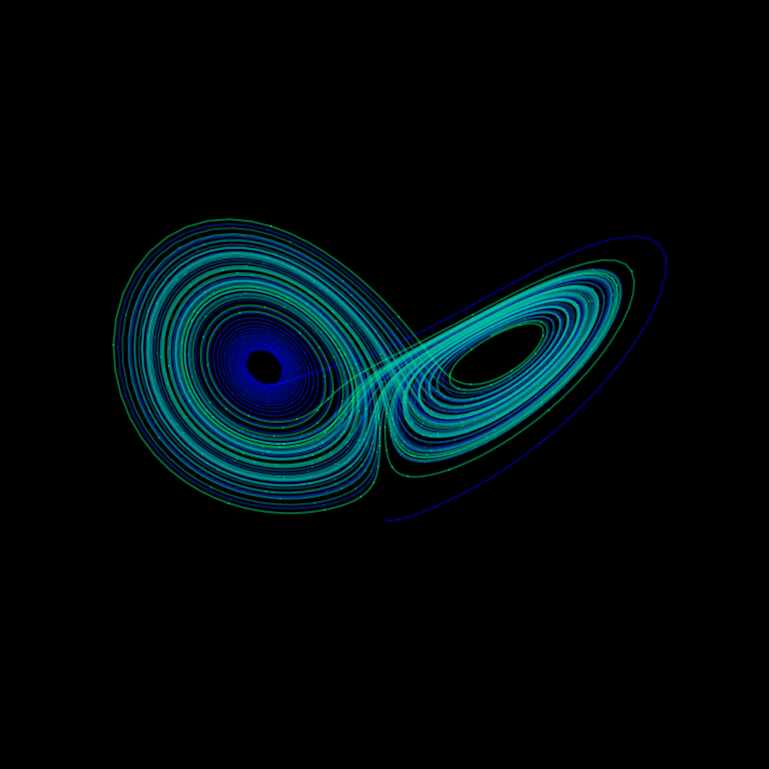

In [1]:
from snn_dpe.tools.data.lorenz import *

"Create a class for the lorenz dataset"

ld=Lorenz_Dataset(sigma=10,beta=8/3,rho=28)

ld.create_dataset(x0=0,y0=1,z0=1.05,tmax=100,n=10000) #x0,y0,z0 intial value, tmax=max time, n= number of samples

ld.plot_data(WIDTH=1000, HEIGHT=750, DPI=100,s = 10,save=False, Filename='lorenz.png') #save=True if the image to image with filname

ld_data=ld.full_data #Full dataset of lorenz, size (n,3) here

ld_x,ld_y,ld_z=ld.X,ld.Y,ld.Z #If sepeparate x,y,z is required

"This is the openml lorenz dataset which has different sigma, beta and rho value"

ld.create_openml_lorenz_data()

ld_data_openml=ld.openml_full_data

